In [0]:
!pip install pyro-ppl

    100% |████████████████████████████████| 215kB 25.3MB/s 
    100% |████████████████████████████████| 61kB 22.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/65/89/2b/1e8facc32da9dbd01a6ad343300cd09a5506f538f4b6407a32
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum


In [0]:
import numpy as np

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import torchvision

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS

import matplotlib.pyplot as plt


In [0]:
train = torchvision.datasets.MNIST('./mnist', train=True , download=True)
test  = torchvision.datasets.MNIST('./mnist', train=False, download=True)



0it [00:00, ?it/s]


 85%|████████▌ | 8429568/9912422 [00:01<00:02, 730993.13it/s]
9920512it [00:01, 8300110.96it/s]                            

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 133859.68it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz



 67%|██████▋   | 1105920/1648877 [00:00<00:01, 368216.27it/s]
1654784it [00:00, 2191965.21it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz



  0%|          | 0/4542 [00:00<?, ?it/s]
8192it [00:00, 50371.17it/s]            

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Averager:
    def __init__(self, alpha=0.98):
        self.alpha = alpha
        self.sum = 0
        self.x = 0
    
    def __call__(self, x):
        self.x = self.alpha * self.x + (1 - self.alpha) * x
        self.sum = self.alpha * self.sum + (1 - self.alpha)
        return self.x / self.sum

In [0]:
N = 300
D = 2
K = 1
def build_toy_dataset(N, D, K, sigma=1):
    w = np.random.normal(0.0, 2.0, size=(K, D))
    z = np.random.normal(0.0, 1.0, size=(N, K))
    x_train = np.random.normal(z @ w, 0.5)
    return x_train, w

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda") if use_cuda else torch.device("cpu")

x_train, w_true = build_toy_dataset(N, D, K)
x_train = torch.Tensor(x_train).to(device)
w_true

array([[-0.96576956, -3.22122493]])

In [0]:
N = 60000
D = 28 * 28
K = 10
x_train    = train.data.to(device, torch.float32).reshape(-1, 28 * 28)
train_mean = x_train.mean()
train_std  = (x_train.std() + 1e-6)
x_train    = (x_train - train_mean) / train_std

In [0]:
def model(x):
    N = x.shape[0]
    w = pyro.sample('w', dist.Normal(x.new_zeros(K, D), 1 * x.new_ones(K, D)).to_event(2))
    
    with pyro.plate('data_batch'):
        v = pyro.sample('v', dist.HalfNormal(torch.Tensor([2.0]).to(device)))
        z = pyro.sample('z', dist.Normal(x.new_zeros(N, K), x.new_ones(N, K)).to_event(1))
        y = pyro.sample('y', dist.Normal(z @ w, v).to_event(1), obs=x)


In [0]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, num_samples=500, warmup_steps=200).run(x_train)

Warmup:   1%|          | 7/700 [02:02<6:32:46, 34.01s/it, step size=1.78e-06, acc. rate=0.857]


KeyboardInterrupt: ignored

(array([ 2.,  1.,  1.,  2.,  1.,  1.,  3.,  1.,  4.,  6.,  2.,  0.,  2.,
         6.,  2.,  5.,  6.,  4.,  6.,  3.,  5.,  4., 10.,  7.,  7.,  8.,
         6.,  7., 12., 14.,  8., 11., 17., 10.,  7.,  8., 10., 13., 12.,
        12.,  8.,  5.,  8., 12., 12., 14., 12.,  3., 11., 14.,  7.,  5.,
         5., 10.,  5.,  4.,  6., 12., 11.,  9.,  6.,  7.,  3.,  1.,  5.,
         3.,  4.,  4.,  6.,  2.,  2.,  4.,  4.,  0.,  2.,  1.,  2.,  0.,
         0.,  7.,  1.,  2.,  0.,  0.,  2.,  4.,  1.,  1.,  0.,  0.,  0.,
         0.,  2.,  1.,  0.,  1.,  1.,  0.,  1.,  1.]),
 array([0.45662475, 0.45771463, 0.45880451, 0.45989439, 0.46098427,
        0.46207415, 0.46316403, 0.46425391, 0.46534379, 0.46643368,
        0.46752356, 0.46861344, 0.46970332, 0.4707932 , 0.47188308,
        0.47297296, 0.47406284, 0.47515272, 0.47624261, 0.47733249,
        0.47842237, 0.47951225, 0.48060213, 0.48169201, 0.48278189,
        0.48387177, 0.48496165, 0.48605154, 0.48714142, 0.4882313 ,
        0.48932118, 0.4904

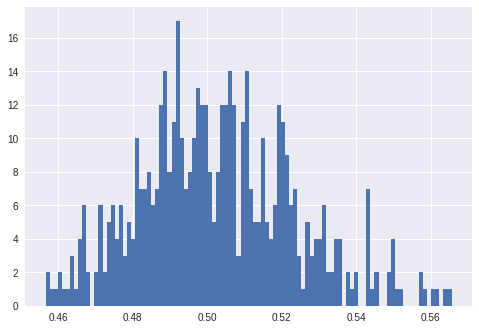

In [0]:
plt.hist(pyro.infer.EmpiricalMarginal(mcmc_run, 'v')._samples.cpu().numpy(), bins=100)

In [0]:
w_true

array([[-3.79329533,  1.74668761]])

In [0]:
def guide(x):
    zw = pyro.param('zw', torch.randn(D, K, device=device))
    zu = pyro.param('zu', 0.02 * x.new_ones(K), constraint=constraints.positive)
    
    w = pyro.sample('w', dist.Normal(
        pyro.param('w/loc', 0.01 * torch.randn(K, D, device=device)),
        pyro.param('w/scale', 0.02 * x.new_ones(K, D), constraint=constraints.positive)).to_event(2))

    with pyro.plate('data_batch'):
        v_loc   = pyro.param('v/loc'  , x.new_ones(1))
        v_scale = pyro.param('v/scale', x.new_ones(1))
        #v = pyro.sample('v', dist.Gamma(F.softplus(v_loc**2 / v_scale**2), F.softplus(v_loc / v_scale**2)).to_event(0))
        v = pyro.sample('v', dist.LogNormal(v_loc, F.softplus(v_scale)))
        #v = pyro.sample('v', dist.Normal(x.new_ones(1), 0.02 * x.new_ones(1)))

        z = pyro.sample('z', dist.Normal(x @ zw, zu).to_event(1))



Epoch     0 Loss 511472.028
Epoch     2 Loss 406475.838
Epoch     4 Loss 362516.035
Epoch     6 Loss 287748.699
Epoch     8 Loss 250885.813
Epoch    10 Loss 239777.645
Epoch    12 Loss 215759.408
Epoch    14 Loss 206643.805
Epoch    16 Loss 200414.148
Epoch    18 Loss 194319.418
Epoch    20 Loss 192325.604
Epoch    22 Loss 189034.640
Epoch    24 Loss 186891.724
Epoch    26 Loss 185760.583
Epoch    28 Loss 185054.906
Epoch    30 Loss 184284.423
Epoch    32 Loss 183213.557
Epoch    34 Loss 182643.980
Epoch    36 Loss 181718.176
Epoch    38 Loss 181419.250
Epoch    40 Loss 180603.547
Epoch    42 Loss 181110.972
Epoch    44 Loss 180099.635
Epoch    46 Loss 179484.040
Epoch    48 Loss 179992.764


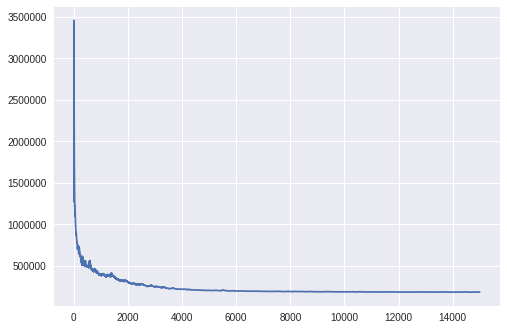

In [0]:
pyro.clear_param_store()
pyro.enable_validation(True)

svi = pyro.infer.SVI(model=model
                    ,guide=guide
                    ,optim=pyro.optim.Adam({'lr': 0.008})
                    ,loss=pyro.infer.Trace_ELBO())

#trace = pyro.poutine.trace(guide).get_trace(train_data.reshape(-1, 100, 28 * 28))
#trace.compute_log_prob()
#print(trace.format_shapes())

losses = []
loss_avg = Averager()
for epoch in range(50):
    for batch in range(300):
        losses.append(loss_avg(svi.step(x_train[batch*200:(batch+1)*200])))
    if epoch % 2 == 0:
        print('Epoch {:>5d} Loss {:.3f}'.format(epoch, losses[-1]))

plt.plot(losses)

In [0]:
pyro.param('w/loc').shape

torch.Size([10, 784])

In [0]:
pyro.param('zw').shape

torch.Size([784, 10])

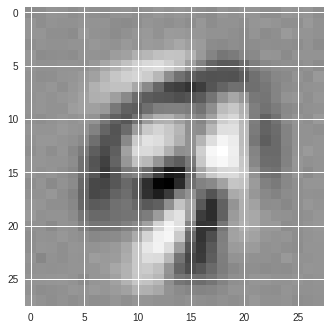

In [0]:
plt.imshow(pyro.param('w/loc').detach().cpu().numpy()[9].reshape(28, 28))

In [0]:
w_true

array([[-0.96576956, -3.22122493]])

In [0]:
pyro.param('w/scale')

tensor([[0.0528, 0.0538, 0.0550,  ..., 0.0509, 0.0509, 0.0524],
        [0.0528, 0.0540, 0.0547,  ..., 0.0512, 0.0577, 0.0563],
        [0.0529, 0.0529, 0.0535,  ..., 0.0561, 0.0518, 0.0521],
        ...,
        [0.0237, 0.0226, 0.0258,  ..., 0.0214, 0.0216, 0.0204],
        [0.0568, 0.0541, 0.0508,  ..., 0.0535, 0.0513, 0.0523],
        [0.0665, 0.0607, 0.0670,  ..., 0.0639, 0.0712, 0.0674]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [0]:
F.softplus(pyro.param('v/loc').detach())

tensor([0.5067], device='cuda:0')

In [0]:
params = pyro.get_param_store()
params = {name: params[name].detach() for name in params}

z = torch.randn((x_train.shape[0], K), device=device) * (x_train @ params['zw']) + params['zu']
x = torch.randn((x_train.shape[0], D), device=device) * (z @ params['w/loc'])
#z = torch.randn(x_train @ params['zw'], params['zu'])
#x = torch.randn(z @ params['w'], 0)

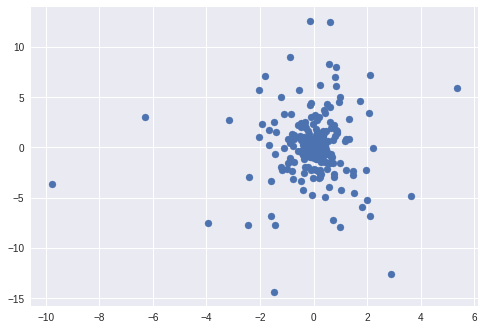

In [0]:
plt.scatter(x[:,0].cpu().numpy(), x[:,1].cpu().numpy())

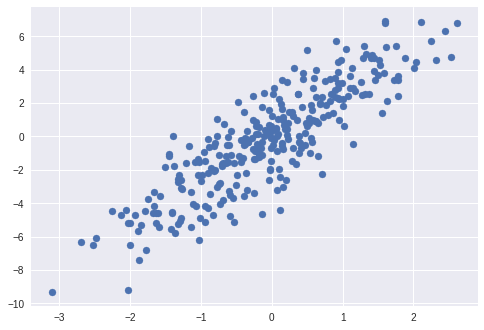

In [0]:
plt.scatter(x_train[:,0].cpu().numpy(), x_train[:,1].cpu().numpy())

In [0]:
torch.randn([2, 2])

tensor([[ 0.1809, -0.6679],
        [ 0.2742, -1.0005]])